<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/07_Time_Series_Classification_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

# TST (Time Series Transformer) 🤗


> This is an unofficial PyTorch implementation by Ignacio Oguiza of  - oguiza@gmail.com based on:

* Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). **A Transformer-based Framework for Multivariate Time Series Representation Learning**. arXiv preprint arXiv:2010.02803v2.
* No official implementation available as far as I know (Oct 10th, 2020)

* This paper uses 'Attention is all you need' as a major reference:
    * Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). **Attention is all you need**. In Advances in neural information processing systems (pp. 5998-6008).

This implementation is adapted to work with the rest of the `tsai` library, and contain some hyperparameters that are not available in the original implementation. I included them to experiment with them. 

## TST *args and **kwargs

Usual values are the ones that appear in the "Attention is all you need" and "A Transformer-based Framework for Multivariate Time Series Representation Learning" papers. 

The default values are the ones selected as a default configuration in the latter.

* c_in: the number of features (aka variables, dimensions, channels) in the time series dataset. dls.var
* c_out: the number of target classes. dls.c
* seq_len: number of time steps in the time series. dls.len
* max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues. Default. None.
* d_model: total dimension of the model (number of features created by the model). Usual values: 128-1024. Default: 128.
* n_heads:  parallel attention heads. Usual values: 8-16. Default: 16.
* d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
* d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
* d_ff: the dimension of the feedforward network model. Usual values: 256-4096. Default: 256.
* dropout: amount of residual dropout applied in the encoder. Usual values: 0.-0.3. Default: 0.1.
* activation: the activation function of intermediate layer, relu or gelu. Default: 'gelu'.
* num_layers: the number of sub-encoder-layers in the encoder. Usual values: 2-8. Default: 3.
* fc_dropout: dropout applied to the final fully connected layer. Usual values: 0-0.8. Default: 0.
* pe: type of positional encoder. Available types: None, 'gauss' (default), 'lin1d', 'exp1d', '2d', 'sincos', 'zeros'. Default: 'gauss'.
* learn_pe: learned positional encoder (True, default) or fixed positional encoder. Default: True.
* flatten: this will flattent the encoder output to be able to apply an mlp type of head. Default=True.
* custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function). Default: None.
* y_range: range of possible y values (used in regression tasks). Default: None
* kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.

## Tips on how to use transformers:

* In general, transformers require a lower lr compared to other time series models when used with the same datasets. It's important to use `learn.lr_find()` to learn what a good lr may be. 

* The paper authors recommend to standardize data by feature. This can be done by adding `TSStandardize(by_var=True` as a batch_tfm when creating the `TSDataLoaders`.

* When using TST with a long time series, you may use `max_w_len` to reduce the memory size and thus avoid gpu issues.`

* I've tried different types of positional encoders. In my experience, the default one works just fine.

* In some of the cases I've used it, you may need to increase the dropout > .1 and/ or fc_dropout > 0 in order to achieve a good performance. 

* You may also experiment with other key hyperparameters like d_model, n_layers, n_heads, etc, but I have not seen major difference in my experience. 

# Import libraries 📚

In [1]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
# stable = False # True: stable version in pip, False: latest version from github
# if stable: 
#     !pip install tsai -U >> /dev/null
# else:      
#     !pip install git+https://github.com/timeseriesAI/tsai.git -U >> /dev/null
# ## NOTE: REMEMBER TO RESTART (NOT RECONNECT/ RESET) THE KERNEL/ RUNTIME ONCE THE INSTALLATION IS FINISHED

In [7]:
from tsai.all import *


computer_setup()

print('cuda available')
print(torch.cuda.is_available())
print('current gpu')
print(torch.cuda.current_device())



os             : Windows-10-10.0.19042-SP0
python         : 3.8.12
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.10.1
n_cpus         : 8
device         : cuda (NVIDIA GeForce MX150)
cuda available
True
current gpu
0


# Load data 🔢

In [13]:
print(get_UCR_multivariate_list())

['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']


In [14]:
#dsid = 'FaceDetection' 

#dsid = 'StandWalkJump'
dsid='BasicMotions'

X, y, splits = get_UCR_data(dsid, return_split=False)
print(X.shape, y.shape)

(80, 6, 100) (80,)


# TST baseline 🧢

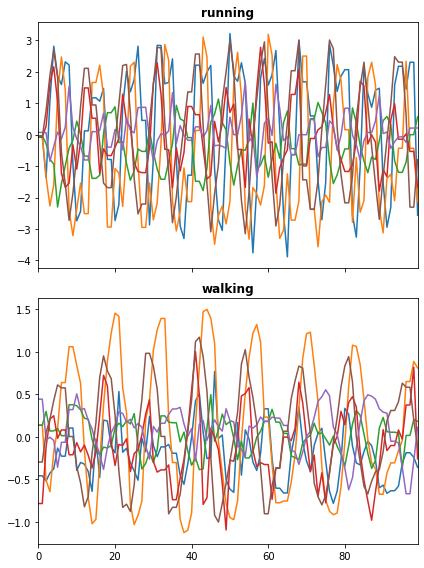

In [19]:
bs = 2
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize(by_var=True))
dls.show_batch()

SuggestedLRs(valley=0.00019054606673307717)

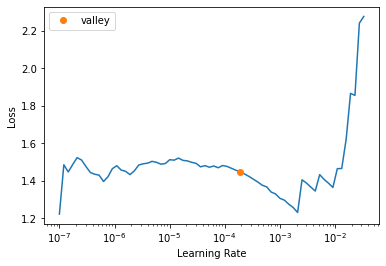

In [20]:
import torch
gc.collect()
torch.cuda.empty_cache()

model = TST(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,1.377057,1.341207,0.639167,0.275000,00:01
1,1.332287,1.318389,0.662500,0.450000,00:01
2,1.308138,1.265939,0.720000,0.575000,00:01
3,1.285447,1.246179,0.758333,0.650000,00:01
4,1.249552,1.204992,0.797500,0.700000,00:01
5,1.199838,1.161248,0.840833,0.725000,00:01
6,1.131354,1.101767,0.900000,0.750000,00:01
7,1.048102,1.039010,0.935833,0.750000,00:01
8,0.984230,1.003300,0.945000,0.700000,00:01
9,0.915919,0.966918,0.958333,0.725000,00:01


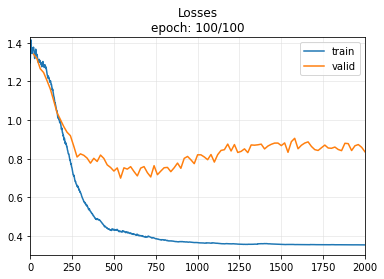

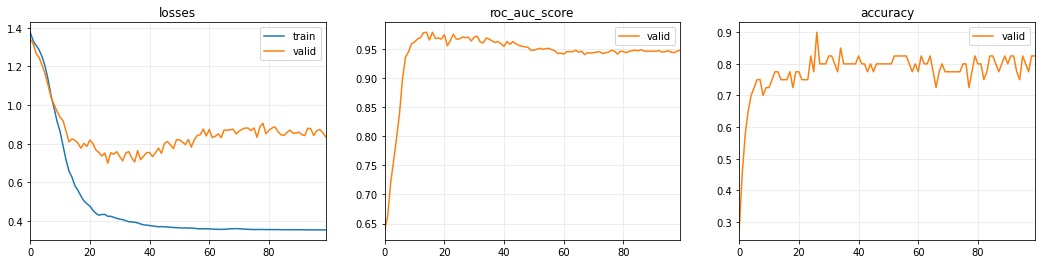


Elapsed time: 159.85499787330627


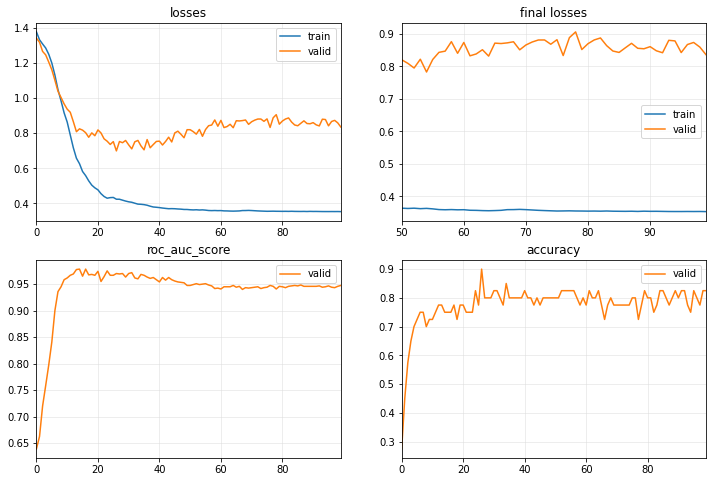

In [21]:
model = TST(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=1e-4)
print('\nElapsed time:', time.time() - start)
learn.plot_metrics()

# How to improve performance with TST? ➕

The model clearly overfits in this task. To try and improve performance I will increase dropout. There are 2 types of dropout in TST: 

* applied to the MHAttention and Feed-Forward layers. Usually 0-0.3. Default: 0.1.

* applied to the fully connected head. Usually 0-0.8. Default: 0.

Let's see what's the impact of these 2 hyperparameters, used independently and combined.

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,1.445551,1.405710,0.531667,0.350000,00:01
1,1.395969,1.378328,0.570833,0.375000,00:01
2,1.370942,1.362940,0.591667,0.450000,00:01
3,1.337533,1.312404,0.704167,0.550000,00:01
4,1.287269,1.285440,0.755833,0.625000,00:01
5,1.224177,1.254613,0.814167,0.650000,00:01
6,1.207144,1.198202,0.854167,0.775000,00:01
7,1.147431,1.154506,0.882500,0.825000,00:01
8,1.084767,1.131988,0.901667,0.775000,00:01
9,1.027273,1.102822,0.913333,0.800000,00:01


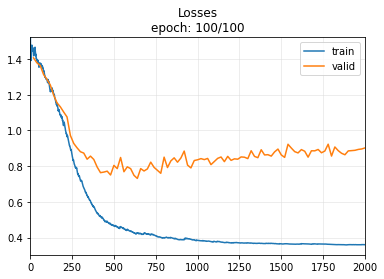

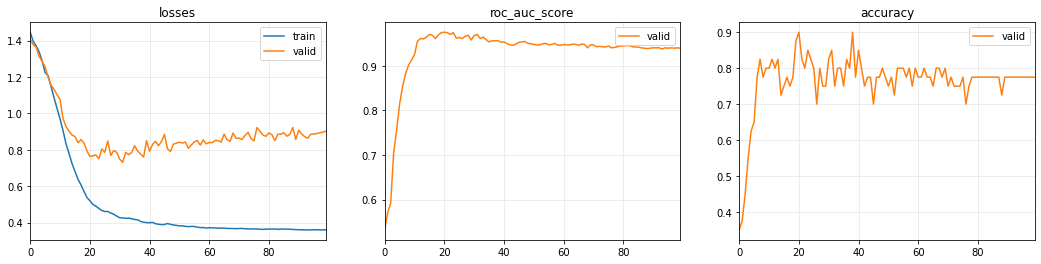


Elapsed time: 153.02836155891418


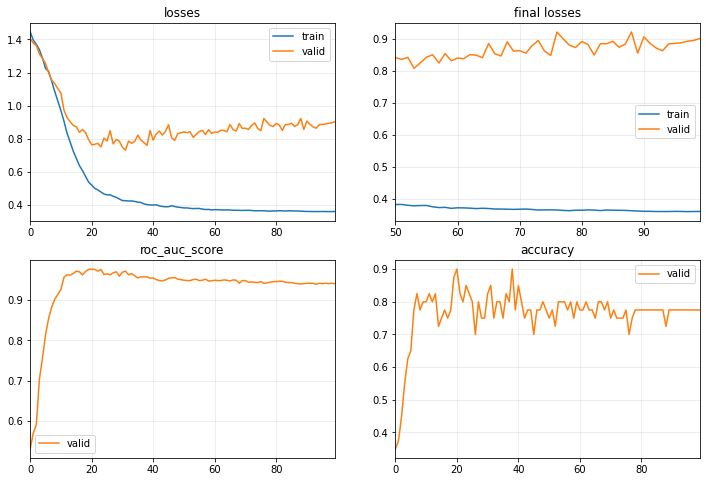

In [31]:
model = TST(dls.vars, dls.c, dls.len, dropout=.3)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=1e-4)
print('\nElapsed time:', time.time() - start)
learn.plot_metrics()
beep()

dropout by itself reduces overfit, but it doesn't eliminate it.

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,1.837069,1.334251,0.682500,0.325000,00:01
1,1.786133,1.323016,0.699167,0.425000,00:01
2,1.777848,1.298238,0.743333,0.450000,00:01
3,1.733594,1.273046,0.796667,0.550000,00:01
4,1.634680,1.246370,0.830833,0.625000,00:01
5,1.612670,1.208673,0.868333,0.700000,00:01
6,1.587161,1.183064,0.894167,0.675000,00:01
7,1.534177,1.132878,0.917500,0.725000,00:01
8,1.430336,1.099462,0.939167,0.725000,00:01
9,1.367402,1.069054,0.957500,0.750000,00:01


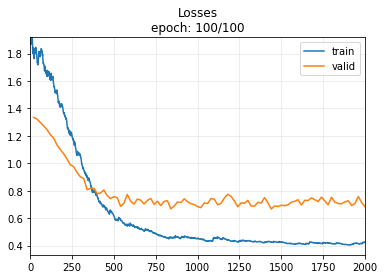

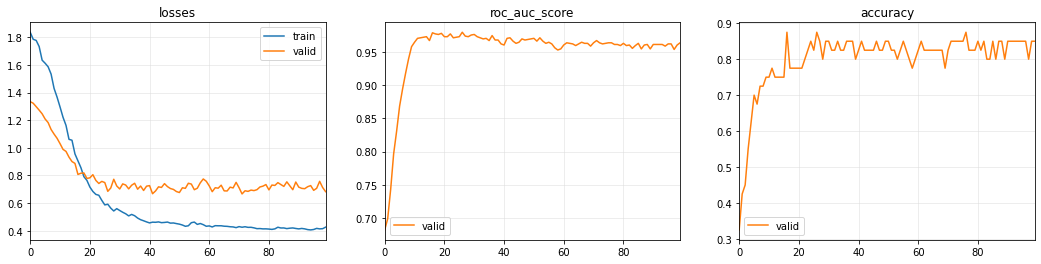


Elapsed time: 172.55168843269348


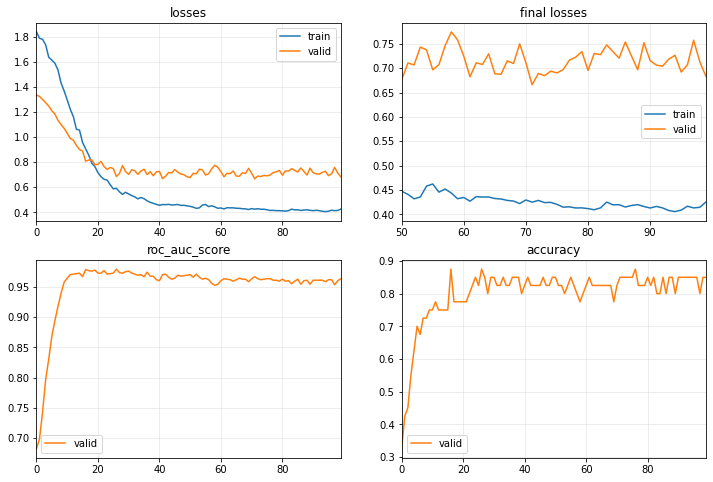

In [32]:
model = TST(dls.vars, dls.c, dls.len, dropout=.1, fc_dropout=.8)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=1e-4)
print('\nElapsed time:', time.time() - start)
learn.plot_metrics()
beep()

It still slightly overfits, although it's much better than the original settings. 

Now let's try both together.

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,1.627470,1.408266,0.475000,0.300000,00:01
1,1.608164,1.397259,0.507500,0.300000,00:01
2,1.609218,1.385661,0.531667,0.325000,00:01
3,1.638961,1.373716,0.565833,0.375000,00:01
4,1.594875,1.356010,0.616667,0.375000,00:01
5,1.574624,1.333301,0.685833,0.425000,00:01
6,1.580652,1.309056,0.725000,0.500000,00:01
7,1.549134,1.276786,0.764167,0.550000,00:01
8,1.476523,1.228168,0.798333,0.550000,00:01
9,1.459153,1.212304,0.825000,0.600000,00:01


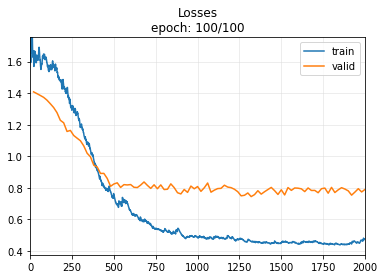

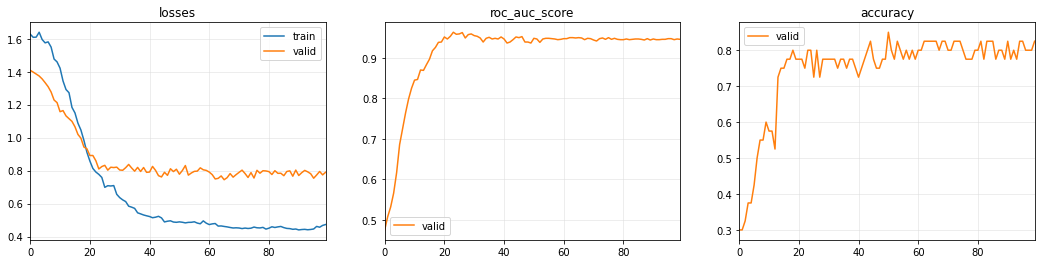


Elapsed time: 178.91823315620422


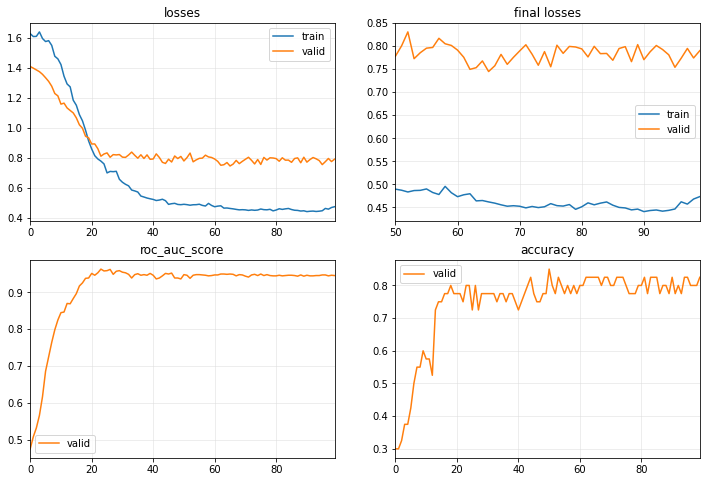

In [33]:
model = TST(dls.vars, dls.c, dls.len, dropout=.3, fc_dropout=.8)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=1e-4)
print('\nElapsed time:', time.time() - start)
learn.plot_metrics()
beep()

Let's check what happens if we increase dropout a bit more...

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,1.962563,1.377566,0.551667,0.250000,00:01
1,1.857216,1.377725,0.554167,0.250000,00:01
2,1.760490,1.368795,0.553333,0.250000,00:01
3,1.806612,1.351858,0.575000,0.275000,00:01
4,1.815448,1.349381,0.590833,0.300000,00:01
5,1.840597,1.336228,0.603333,0.475000,00:01
6,1.743298,1.319982,0.641667,0.475000,00:01
7,1.703278,1.293541,0.684167,0.525000,00:01
8,1.760764,1.275221,0.756667,0.550000,00:01
9,1.659983,1.245672,0.791667,0.575000,00:01


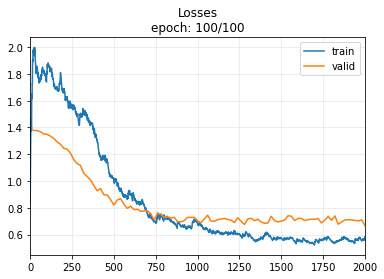

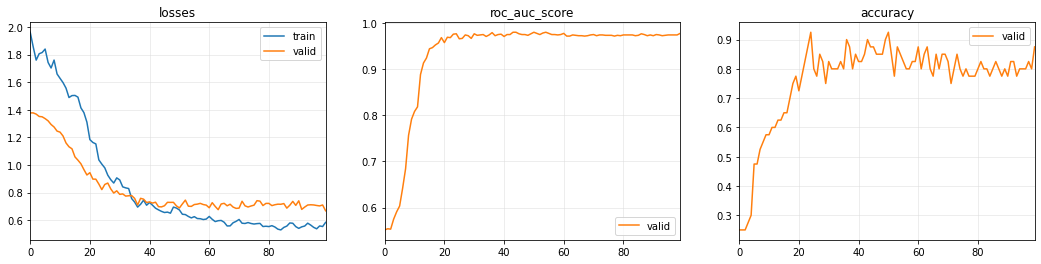

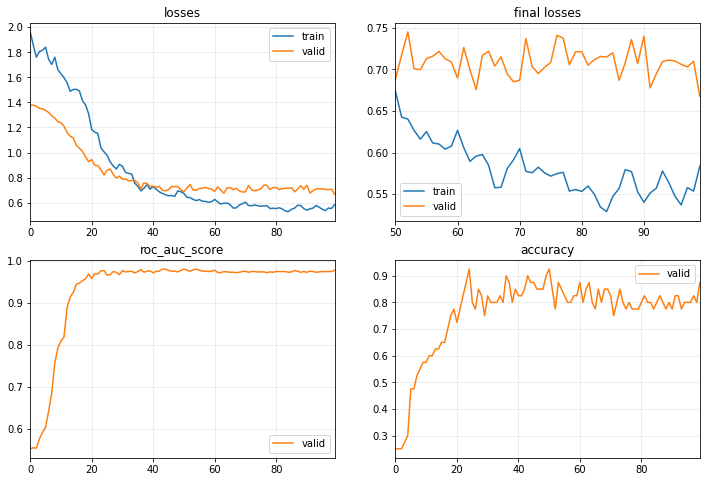

In [34]:
model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.9)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
n_epochs = 100
learn.fit_one_cycle(n_epochs, 1e-4) 
learn.plot_metrics()
beep()

This is a great result, beyond InceptionTime and any other the state-of-the-art papers I've seen.

# Conclusion ✅

TST (Time Series Transformer) seems like a great addition to the world of time series models.

The model trains very smoothly and overfitting can be reduced/ eliminated by using dropout.

Also, TST is about 10% faster to train that InceptionTime.
Here's all the code you need to train a transformer model with `tsai`:

```
X, y, splits = get_UCR_data('FaceDetection', return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=TSStandardize(by_var=True))
model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.9)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), 
                metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.fit_one_cycle(100, 1e-4) 
```